In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
import warnings

from src import data, paths, centroids, matrix_filtering

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib inline

!date -I

2024-05-09


## Settings

In [2]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION = "MNI-HCP-MMP1"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False

# True for 50 ms version, 200 ms version otherwise
FTRACT_SHORT = True

ED_threshold = 20
min_streamlines = 5
graph_density = 0.25

selected_SC_matrices = ["Mica-Mics_rh","Rosen-Halgren_rh"]

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

In [3]:
fig_dir = f"ftract_results_per_roi/{'short' if FTRACT_SHORT else 'long'}/{PARCELLATION}/ED{ED_threshold}/{graph_density}/"
%mkdir -p  {paths.path_figures(fig_dir)}

## Load data

### Load F-TRACT data

In [4]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
response_probability, response_amplitude, response_onset_delay, response_peak_delay, n_stim, n_impl, ftract_labels = data.load_ftract(PARCELLATION,short=FTRACT_SHORT)

if PARCELLATION == "DKT":
    for a in [0,1]:
        response_probability = np.delete(response_probability,ids_to_delete_in_dkt,axis=a)
        response_amplitude = np.delete(response_amplitude,ids_to_delete_in_dkt,axis=a)
        response_onset_delay = np.delete(response_onset_delay,ids_to_delete_in_dkt,axis=a)
        response_peak_delay = np.delete(response_peak_delay,ids_to_delete_in_dkt,axis=a)
        n_stim = np.delete(n_stim,ids_to_delete_in_dkt,axis=a)
        n_impl = np.delete(n_impl,ids_to_delete_in_dkt,axis=a)

### Load Euclidean distances

In [5]:
if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    
elif PARCELLATION == "MNI-HCP-MMP1":
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)

### Define mask

In [6]:
mask = np.logical_and(np.logical_and(n_stim > 100, n_impl > 5),ED>ED_threshold)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    mask_amp = mask
else:
    mask_amp = (n_stim*response_probability)>=100

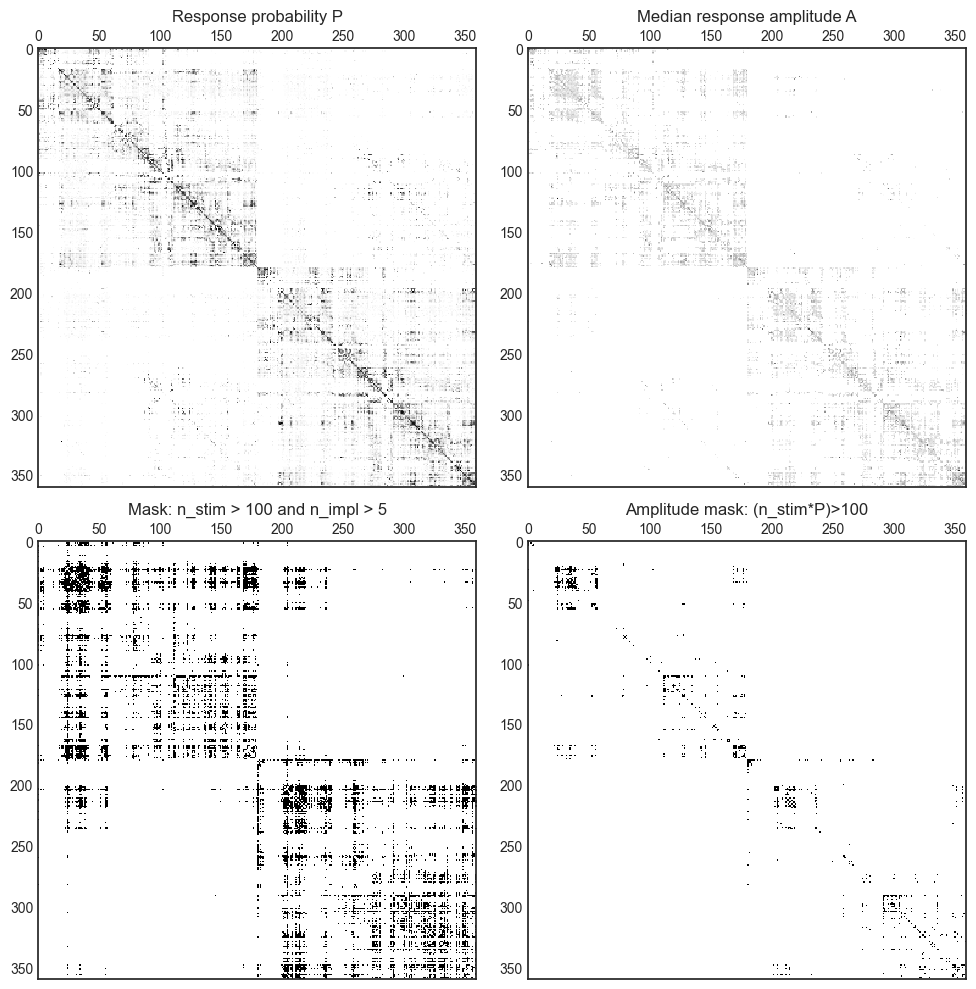

In [7]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].matshow(response_probability)
axs[0,0].set_title("Response probability P")
axs[0,1].matshow(np.log(response_amplitude))
axs[0,1].set_title("Median response amplitude A")
axs[1,0].matshow(mask)
axs[1,0].set_title("Mask: n_stim > 100 and n_impl > 5")
axs[1,1].matshow(mask_amp)

if AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK:
    axs[1,1].set_title("Amplitude mask same as mask")
else:
    axs[1,1].set_title("Amplitude mask: (n_stim*P)>100")

### Load structural connectivity data

In [8]:
SC_matrices = []

if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ids_to_delete_in_dkt,ED,min_streamlines_count=min_streamlines)
    

elif PARCELLATION == "MNI-HCP-MMP1":
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ED,min_streamlines_count=min_streamlines)

number_of_SC = len(SC_matrices)

/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


In [9]:
SC_matrices_filtered = []

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data
    pivot = matrix_filtering.find_pivot_to_keep_xpercent_edges(SC_W,graph_density)
    SC_W = np.where(SC_W>=pivot,SC_W,0)
    if SC_L is not None:
        SC_L = np.where(SC_W>=pivot,SC_L,np.nan)
    SC_W_log = np.where(SC_W>=pivot,SC_W_log,np.nan)
    SC_matrices_filtered.append((name, SC_W, SC_L, SC_W_log))

SC_matrices = SC_matrices_filtered

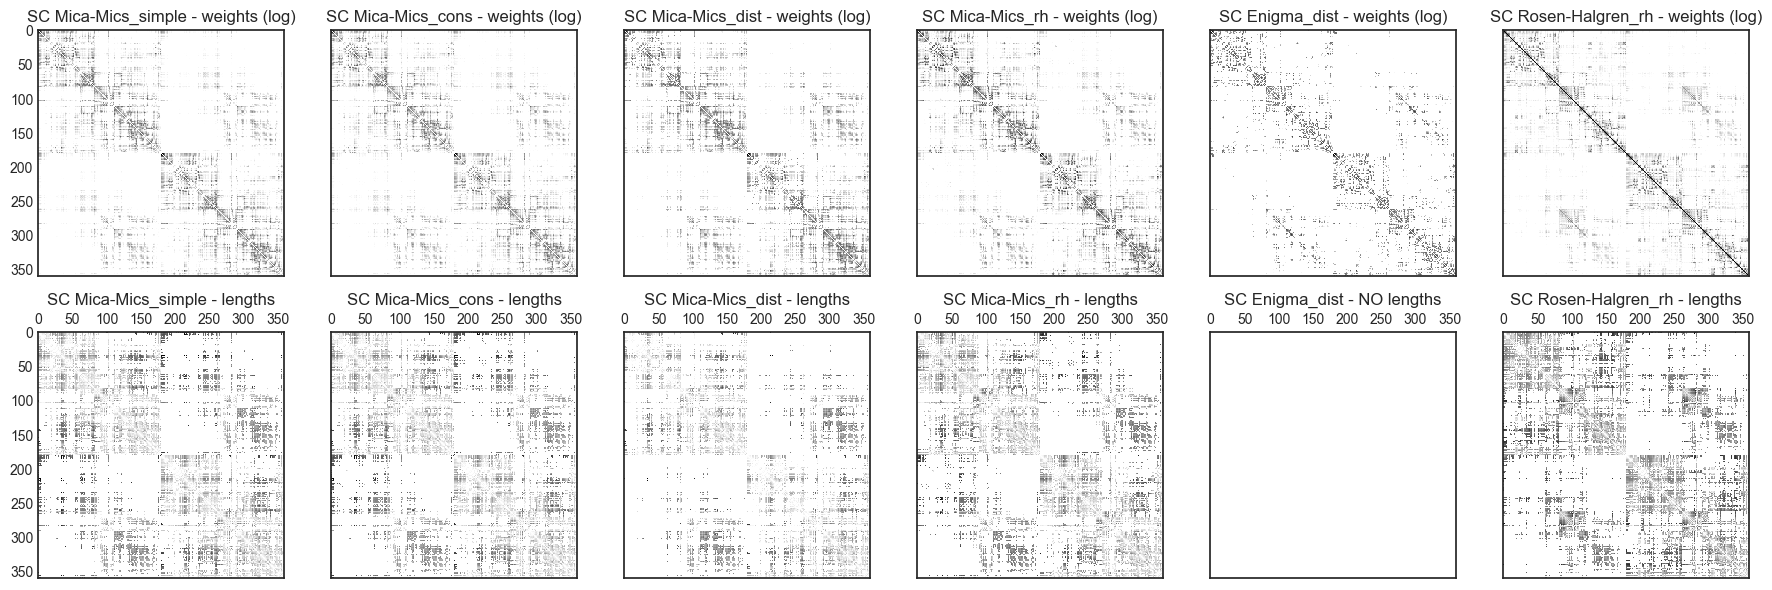

In [10]:
plt.rcParams['figure.figsize'] = [3*number_of_SC,6]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")

    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

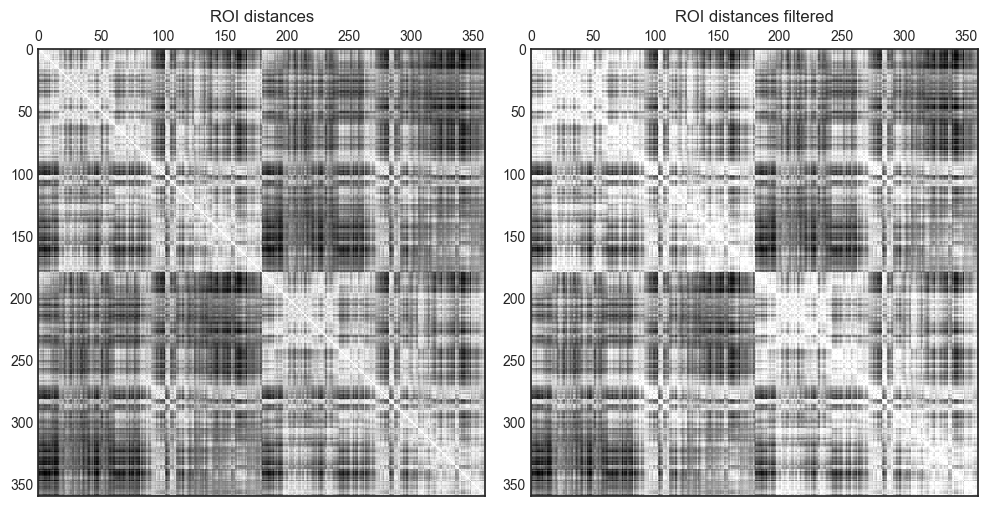

In [11]:
if ED is not None:
    fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(10,5))

    axs[0].matshow(ED)
    axs[0].set_title("ROI distances")
    ED_filtered = np.where(ED>ED_threshold,ED,np.nan)
    axs[1].matshow(ED_filtered)
    axs[1].set_title("ROI distances filtered")
    plt.show()

## Correlations

In [12]:
def calculate_communicatin_metrics(ED,SC_L,SC_W,name=None):
    metrics_dict = dict()

    metrics_dict["ED"] = ED
    metrics_dict["SC_W"] = SC_W
    
    if SC_L is not None:
        metrics_dict["SC_L"] = SC_L

    # shortest path efficiency
    if SC_L is not None:
            shortest_paths,_ = metrics.distance_wei_floyd(SC_L)
            metrics_dict["SPE"] = np.divide(1,shortest_paths)
    else:
        print(f"Edge lengths not availible for {name}, 1/SC_W used for SPE instead")
        shortest_paths,_ = metrics.distance_wei_floyd(1/SC_W)
        metrics_dict["SPE"] = np.divide(1,shortest_paths)

    # communicability
    metrics_dict["COM"] = metrics.communicability_wei(np.nan_to_num(SC_W,nan=0))

    # SI
    metrics_dict["SI"] = metrics.search_information(SC_W,ED)

    # SI with length
    if SC_L is not None:
         metrics_dict["SI_L"] = metrics.search_information(SC_W,SC_L)

    # navigation path eff.
    _,_,nav_paths,_,_ = metrics.navigation_wu(ED, SC_W)
    metrics_dict["NAV"] = np.divide(1,nav_paths)
    
    # navigation path eff. with L
    if SC_L is not None:
        _,_,_,_,nav_paths = metrics.navigation_wu(ED, SC_W)
        nav_paths = metrics.get_navigation_path_length(nav_paths, SC_L)
        metrics_dict["NAV"] = np.divide(1,nav_paths)


    _, metrics_dict["DIF"] = metrics.diffusion_efficiency(SC_W)
    
    return metrics_dict

In [13]:
def df_per_roi(response,mask,metrics_dict,ftract_labels):

    masked_response = np.where(mask,response,np.nan)

    # apply mask to all matrices
    for m in metrics_dict:
        metrics_dict[m] = np.where(mask,metrics_dict[m],np.nan)

    temp = dict()
    for roi,label in enumerate(ftract_labels):
        df_per_roi = pd.DataFrame()
        response_per_roi = masked_response[roi,:]
        if np.isnan(response_per_roi).all():
            continue
        df_per_roi["response"] = pd.Series(response_per_roi)
        for m in metrics_dict:
            m_masked = metrics_dict[m]
            df_per_roi[m] = pd.Series(m_masked[roi,:])

        temp[label] = df_per_roi
    
    df = pd.concat(temp)
        
    return df

In [14]:
stat_data_per_roi = {}

for name, SC_W, SC_L, SC_W_log in SC_matrices:

    # this is necessary to supress warnings for some types of matrices
    if SC_L is not None:
        SC_L = np.ascontiguousarray(SC_L)
    SC_W = np.ascontiguousarray(SC_W)

    # supress warnings - all the warnings we saw were about zero division,
    # they result into nans in matrices, but they can not cause any issues
    # (we checked the code where the warnings occured)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        metrics_dict = calculate_communicatin_metrics(ED,SC_L,SC_W,name)

    df_probability = pd.DataFrame({"response_probability":response_probability[mask].flatten()})
    df_amplitude = pd.DataFrame({"response_amplitude":response_amplitude[mask_amp].flatten()})

    df_probability = df_per_roi(response_probability,mask,metrics_dict,ftract_labels)
    df_amplitude = df_per_roi(response_amplitude,mask_amp,metrics_dict,ftract_labels)

    stat_data_per_roi[name] = {"probability":df_probability,"amplitude":df_amplitude}

Edge lengths not availible for Enigma_dist, 1/SC_W used for SPE instead


In [23]:
def partial_corr_ED(d,x,method):
    result = []
    result.append(pd.DataFrame({"n":[0],"r":[0],"CI95%":[None],"p-val":[1],"Y":["ED"]})) # just to have fitting images

    for k in d.keys():
        if k == "ED" or k == x or np.count_nonzero(d[x])<3 or np.count_nonzero(d[k])<3:
            continue
        df_one_result = pg.partial_corr(data=d,x=x,y=k,covar="ED", method=method)
        df_one_result['Y'] = k
        result.append(df_one_result)
    
    return pd.concat(result)

def corr_per_roi(df):
    r_per_roi = dict()
    for label in list(set(df.index.get_level_values(0))):
        relevant_df = df.xs(label, drop_level=False)

        # we need enoug non-zero values, otherwise the correlation does not make sense
        try:
            r_per_roi[label] = pg.pairwise_corr(relevant_df,'response', method='spearman').round(3)
        except:
            pass
        
    return pd.concat(r_per_roi)

def partial_corr_per_roi(df):
    r_per_roi = dict()
    for label in list(set(df.index.get_level_values(0))):
        relevant_df = df.xs(label, drop_level=False)
        # we need enoug non-zero values, otherwise the correlation does not make sense
        try:
            r_per_roi[label] = partial_corr_ED(relevant_df,'response', method='spearman').round(3)
        except:
            pass
    return pd.concat(r_per_roi)

In [24]:
keys = []

result_p_per_roi = []
result_p_partial_per_roi = []

result_a_per_roi = []
result_a_partial_per_roi = []

# 
for name in selected_SC_matrices:
    print(name)
    keys.append(name)
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        # supress warnings about small number of examples (it returns nans if sample size is too small, which is ok in this case)
        result_p_per_roi.append(corr_per_roi(stat_data_per_roi[name]["probability"]).round(3))
        #result_a_per_roi.append(corr_per_roi(stat_data_per_roi[name]["amplitude"]).round(3))
        result_p_partial_per_roi.append(partial_corr_per_roi(stat_data_per_roi[name]["probability"]))
        #result_a_partial_per_roi.append(partial_corr_per_roi(stat_data_per_roi[name]["amplitude"]))

Mica-Mics_rh


Rosen-Halgren_rh


In [25]:
for r in result_p_per_roi+result_p_partial_per_roi:#+result_a_per_roi+result_a_partial_per_roi:
    r['r_abs'] = r['r'].apply(abs)
    #r['CI_size'] = r['CI95%'].apply(lambda x:(x[1]-x[0])/2)
for r in result_p_per_roi:#+result_a_per_roi:
    r['p_sigf'] = r['p-unc'].apply(lambda x: "*" if x< 0.05 else "")
    r['p_sigf_num'] = r['p_sigf'].apply(lambda x: 1 if x=="*" else 0)
    r['r_abs_sigf'] = r.apply(lambda x: x['r_abs'] if (x['p-unc'] < 0.05 and x['n']>=30) else np.nan,axis=1)
for r in result_p_partial_per_roi:#+result_a_partial_per_roi:
    r['p_sigf'] = r['p-val'].apply(lambda x: "*" if x< 0.05 else "")
    r['p_sigf_num'] = r['p_sigf'].apply(lambda x: 1 if x=="*" else 0)
    r['r_abs_sigf'] = r.apply(lambda x: x['r_abs'] if (x['p-val'] < 0.05 and x['n']>=30) else np.nan,axis=1)

result_p_per_roi = pd.concat(result_p_per_roi, keys=keys).reset_index(names=["dataset","roi",'-'])
#result_a_per_roi = pd.concat(result_a_per_roi, keys=keys).reset_index(names=["dataset","roi",'-'])
result_p_partial_per_roi = pd.concat(result_p_partial_per_roi, keys=keys).reset_index(names=["dataset","roi",'-'])
#result_a_partial_per_roi = pd.concat(result_a_partial_per_roi, keys=keys).reset_index(names=["dataset","roi",'-'])

In [26]:
plt.style.use('ggplot')
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#E24A33', '#348ABD', '#8EBA42','#FBC15E', '#777777', '#988ED5', '#FFB5B8']) 

In [27]:
def plot_results(d,title):
    plt.figure(figsize=(7,10))
    
    ax = sns.barplot(data=d, x='Y', y='r_abs',hue="dataset")
    ax.set_title(title)  
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)

    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')

    plt.show()

In [28]:
def plot_results_per_roi(rpr,title=None):
    plt.figure(figsize=(7,7))
    
    ax = sns.boxplot(data=rpr, x="Y", y="r_abs_sigf", hue="dataset",palette=['#E24A33','#777777'])
    ax.set_title(title) 
    ax.set_ylim(bottom=0, top=1)
    ax.tick_params(axis='x', rotation=90)
    plt.xlabel('Communication metric')
    plt.ylabel('Correlation coefficient')
    title_save = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(f'{paths.path_figures(fig_dir+title_save)}.pdf')
    plt.show()

In [29]:
for rpr in [result_p_per_roi,result_p_partial_per_roi]:#,result_a_per_roi,result_a_partial_per_roi]:
    display(rpr.groupby(by=["dataset","Y"])[['r','p_sigf_num','n']].agg({'r':'mean','p_sigf_num':'sum','n':'mean'}))

r  p_sigf_num          n
dataset          Y                                    
Mica-Mics_rh     COM   0.601829         207  31.533557
                 DIF   0.161631          20  31.533557
                 ED   -0.722017         234  31.533557
                 NAV   0.647732         230  31.533557
                 SC_L -0.664538         206  19.125448
                 SC_W  0.520753         196  32.243986
                 SI   -0.520753         196  32.243986
                 SI_L -0.556426         203  31.533557
                 SPE   0.680540         229  31.533557
Rosen-Halgren_rh COM   0.519946         194  31.533557
                 DIF   0.156926          27  31.533557
                 ED   -0.722017         234  31.533557
                 NAV   0.572765         201  31.533557
                 SC_L -0.646342         177  18.683099
                 SC_W  0.477928         176  32.037543
                 SI   -0.477928         176  32.037543
                 SI_L -0.469768         184  31.533557
                 SPE   0.626775         212  31.533557

r  p_sigf_num          n
dataset          Y                                    
Mica-Mics_rh     COM   0.308938         119  35.729730
                 DIF   0.106629          41  35.729730
                 ED    0.000000           0   0.000000
                 NAV   0.320942         117  35.729730
                 SC_L -0.293162          79  20.447876
                 SC_W  0.286452          99  35.729730
                 SI   -0.286452          99  35.729730
                 SI_L -0.285367          99  35.729730
                 SPE   0.312533         125  35.729730
Rosen-Halgren_rh COM   0.217931          90  35.550000
                 DIF   0.061223          36  35.550000
                 ED    0.000000           0   0.000000
                 NAV   0.234396          99  35.550000
                 SC_L -0.262769          74  20.223077
                 SC_W  0.194450          79  35.550000
                 SI   -0.194450          79  35.550000
                 SI_L -0.239188          83  35.550000
                 SPE   0.250404         100  35.550000

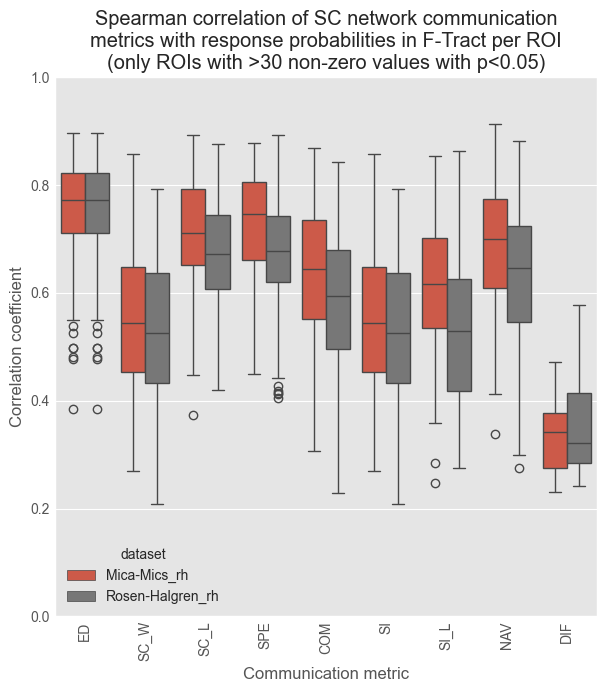

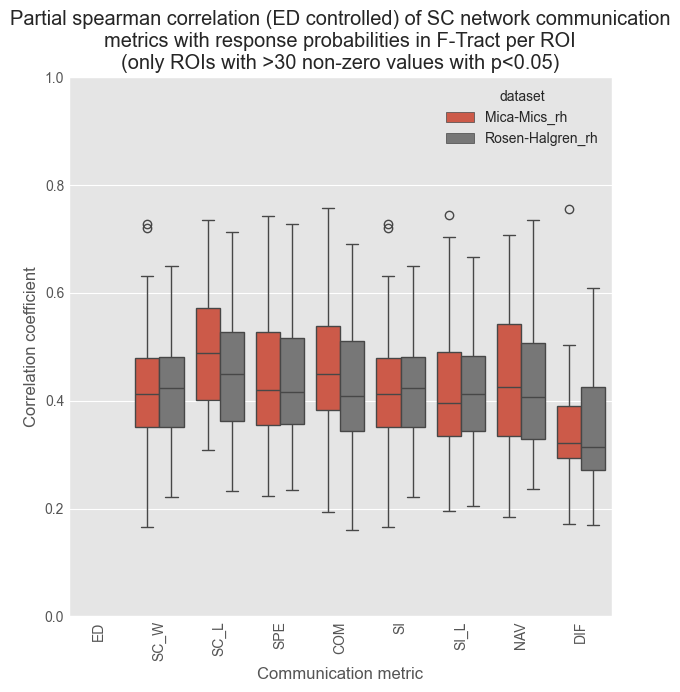

In [30]:
plot_results_per_roi(result_p_per_roi,title="Spearman correlation of SC network communication\nmetrics with response probabilities in F-Tract per ROI\n(only ROIs with >30 non-zero values with p<0.05)")
#plot_results_per_roi(result_a_per_roi,title="Spearman correlation of SC network communication\nmetrics with response amplitudes in F-Tract per ROI\n(only ROIs with >30 non-zero values with p<0.05)")
plot_results_per_roi(result_p_partial_per_roi,title="Partial spearman correlation (ED controlled) of SC network communication\nmetrics with response probabilities in F-Tract per ROI\n(only ROIs with >30 non-zero values with p<0.05)")
#plot_results_per_roi(result_a_partial_per_roi,title="Partial spearman correlation (ED controlled) of SC network communication\nmetrics with response amplitudes in F-Tract per ROI\n(only ROIs with >30 non-zero values with p<0.05)")

In [31]:
stat_m = {}

for name in selected_SC_matrices:
    primary_motor_cortex_l = stat_data_per_roi[name]["probability"].loc["L_4"]
    stat_l = pg.pairwise_corr(primary_motor_cortex_l,'response', method='spearman').round(3)
    primary_motor_cortex_r = stat_data_per_roi[name]["probability"].loc["R_4"]
    stat_r = pg.pairwise_corr(primary_motor_cortex_r,'response', method='spearman').round(3)
    stat = pd.concat({"L_hemi":stat_l,"R_hemi":stat_r})
    stat = stat.reset_index(names=["hemi",'-'])
    stat["r_abs"] = abs(stat["r"])
    stat_m[name] = stat
    #plot_results(stat,title="title")
    display(stat) 

,hemi,-,X,Y,method,alternative,n,r,CI95%,p-unc,power,r_abs
0,L_hemi,0,response,ED,spearman,two-sided,118,-0.685,"[-0.77, -0.57]",0.000,1.000,0.685
1,L_hemi,1,response,SC_W,spearman,two-sided,118,0.541,"[0.4, 0.66]",0.000,1.000,0.541
2,L_hemi,2,response,SC_L,spearman,two-sided,76,-0.749,"[-0.83, -0.63]",0.000,1.000,0.749
3,L_hemi,3,response,SPE,spearman,two-sided,118,0.687,"[0.58, 0.77]",0.000,1.000,0.687
4,L_hemi,4,response,COM,spearman,two-sided,118,0.645,"[0.53, 0.74]",0.000,1.000,0.645
5,L_hemi,5,response,SI,spearman,two-sided,118,-0.541,"[-0.66, -0.4]",0.000,1.000,0.541
6,L_hemi,6,response,SI_L,spearman,two-sided,118,-0.501,"[-0.63, -0.35]",0.000,1.000,0.501
7,L_hemi,7,response,NAV,spearman,two-sided,118,0.671,"[0.56, 0.76]",0.000,1.000,0.671
8,L_hemi,8,response,DIF,spearman,two-sided,118,0.026,"[-0.16, 0.21]",0.778,0.059,0.026
9,R_hemi,0,response,ED,spearman,two-sided,101,-0.689,"[-0.78, -0.57]",0.000,1.000,0.689


,hemi,-,X,Y,method,alternative,n,r,CI95%,p-unc,power,r_abs
0,L_hemi,0,response,ED,spearman,two-sided,118,-0.685,"[-0.77, -0.57]",0.000,1.000,0.685
1,L_hemi,1,response,SC_W,spearman,two-sided,118,0.426,"[0.27, 0.56]",0.000,0.998,0.426
2,L_hemi,2,response,SC_L,spearman,two-sided,69,-0.792,"[-0.87, -0.68]",0.000,1.000,0.792
3,L_hemi,3,response,SPE,spearman,two-sided,118,0.730,"[0.63, 0.8]",0.000,1.000,0.730
4,L_hemi,4,response,COM,spearman,two-sided,118,0.538,"[0.4, 0.65]",0.000,1.000,0.538
5,L_hemi,5,response,SI,spearman,two-sided,118,-0.426,"[-0.56, -0.27]",0.000,0.998,0.426
6,L_hemi,6,response,SI_L,spearman,two-sided,118,-0.411,"[-0.55, -0.25]",0.000,0.997,0.411
7,L_hemi,7,response,NAV,spearman,two-sided,118,0.650,"[0.53, 0.74]",0.000,1.000,0.650
8,L_hemi,8,response,DIF,spearman,two-sided,118,0.004,"[-0.18, 0.18]",0.966,0.050,0.004
9,R_hemi,0,response,ED,spearman,two-sided,101,-0.689,"[-0.78, -0.57]",0.000,1.000,0.689


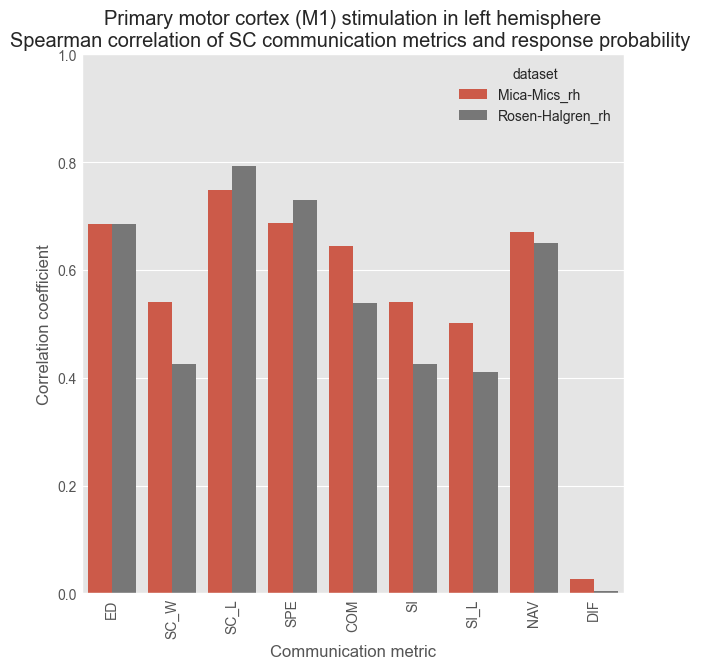

In [32]:
stat_m_df = pd.concat(stat_m).reset_index(names=["dataset",'--'])
plt.figure(figsize=(7,7))
ax = sns.barplot(data=stat_m_df[stat_m_df.hemi=="L_hemi"], x='Y', y='r_abs',hue="dataset",palette=['#E24A33','#777777'])
title="Primary motor cortex (M1) stimulation in left hemisphere\nSpearman correlation of SC communication metrics and response probability "
ax.set_title(title)  
ax.set_ylim(bottom=0, top=1)
ax.tick_params(axis='x', rotation=90)
plt.xlabel('Communication metric')
plt.ylabel('Correlation coefficient')
title_save = (title.replace("\n","_")).replace(" ","_")
plt.savefig(f'{paths.path_figures(fig_dir+title_save)}.pdf')
plt.show()